# Preparação do ambiente

## Bibliotecas

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.auto import tqdm

In [2]:
pd.options.mode.copy_on_write = True

## Constantes e funções auxiliares

In [3]:
DATASETS_ROOT_PATH = Path('../datasets/mercadolivre/20240710')

search_results_folder = DATASETS_ROOT_PATH / 'search_results'
item_details_folder = DATASETS_ROOT_PATH / 'item_details'

In [4]:
def parse_item_details_file(item_details_file):
    keys_to_keep = [
        'id', 
        'title', 
        'seller_id', 
        'category_id', 
        'official_store_id', 
        'price', 
        'currency_id', 
        'initial_quantity',
        'condition', 
        'permalink', 
        'warranty', 
        'catalog_product_id', 
        'date_created', 
        'last_updated', 
        'status'
    ]
    
    attributes_to_keep = [
        'ITEM_CONDITION', 
        'BRAND', 
        'MODEL', 
        'DETAILED_MODEL', 
        'ANATEL_HOMOLOGATION_NUMBER', 
        'CELLPHONES_ANATEL_HOMOLOGATION_NUMBER', 
        'GTIN', 
        'EMPTY_GTIN_REASON',
    ]

    columns_to_keep = [col.lower() for col in keys_to_keep+attributes_to_keep]

    with open(item_details_file) as file:
        item_details = json.load(file)

    if item_details['status']=='under review':
        return None

    if not 'attributes' in item_details.keys():
        return None
    
    parsed_item = {key:None for key in columns_to_keep}    
    for key in keys_to_keep:
        try:
            parsed_item[key] = item_details[key]
        except:
            continue
    
    for item_attribute in item_details['attributes']:
        if item_attribute['id'] in attributes_to_keep:
            attribute_key = item_attribute['id'].lower()
            parsed_item[attribute_key]  = item_attribute['value_name']

    parsed_item['warranty_type'] = None
    if 'sale_terms' in item_details.keys():
        for sale_term in item_details['sale_terms']:
            if sale_term['id'] == 'WARRANTY_TYPE':
                parsed_item['warranty_type'] = sale_term['value_name']

    if parsed_item['anatel_homologation_number'] is not None:
        parsed_item['anatel_homologation_number'] = parsed_item['anatel_homologation_number'].zfill(12)

    if parsed_item['cellphones_anatel_homologation_number'] is not None:
        parsed_item['cellphones_anatel_homologation_number'] = parsed_item['cellphones_anatel_homologation_number'].zfill(12)

    return parsed_item

In [5]:
def parse_item_details_folder(item_details_folder):

    if isinstance(item_details_folder, str):
        item_details_folder = Path(item_details_folder)
    item_details_files = [file for file in item_details_folder.glob('*.json')]

    item_details = [parse_item_details_file(file) for file in tqdm(item_details_files)]
    item_details = [item for item in item_details if item is not None]

    return pd.DataFrame(item_details)

In [6]:
def parse_sellers(search_results_folder):
    
    sellers = []

    search_results_files = list(search_results_folder.glob('*.json'))
    for file in tqdm(search_results_files):
        with open(file) as f:
            content = json.load(f)
            results = content['results']
        
        for result in results:
            
            seller_id = None
            seller_nickname = None
            official_store_id = None
            official_store_name = None
    
    
            if 'seller' in result.keys():
                seller_id = result['seller']['id']
                seller_nickname = result['seller']['nickname']
            
            if 'official_store_id' in result.keys():
                official_store_id = result['official_store_id']
                
            if 'official_store_name' in result.keys():
                official_store_name = result['official_store_name']
            
            sellers.append({
                'seller_id': seller_id, 
                'seller_nickname': seller_nickname, 
                'official_store_id': official_store_id, 
                'official_store_name': official_store_name
            })
    
    df_sellers = pd.DataFrame(sellers)

    df_official_stores = df_sellers[['official_store_id', 'official_store_name']].drop_duplicates()
    df_official_stores['official_store_id'] = df_official_stores['official_store_id'].fillna(-1).astype(int)
    df_official_stores = df_official_stores.reset_index(drop=True)
    
    df_sellers = df_sellers[['seller_id', 'seller_nickname']].drop_duplicates()
    df_sellers['seller_id'] = df_sellers['seller_id'].fillna(-1).astype(int)
    df_sellers = df_sellers.reset_index(drop=True)

    return df_official_stores, df_sellers
    

# Carga e prepação dos dados

## Base SCH

In [7]:
%%time

file_sch = '../datasets/sch/produtos_certificados.zip'
file_cel_5g = '../datasets/sch/celulares_5g_homologados.zip'
file_sch_consolidada = '../datasets/sch/base_sch_consolidada.parquet'

update_homologados = False

if update_homologados:
    
    dtype_sch = {'Número de Homologação': 'str'}
    dtype_cel_5g = {'NumeroHomologacao': 'str'}
    
    sch_columns_to_keep = ['Número de Homologação', 'Nome do Fabricante', 'Tipo do Produto', 'Modelo', 'Nome Comercial']
    cel_5g_columns_to_keep = ['NumeroHomologacao', 'Fabricante', 'TipodeProduto', 'Modelo', 'NomeComercial'] 
    
    df_sch = pd.read_csv(file_sch, sep=';',dtype=dtype_sch)
    df_sch = df_sch[sch_columns_to_keep]
    
    df_cel_5g = pd.read_csv(file_cel_5g, sep=';',dtype=dtype_cel_5g)
    df_cel_5g = df_cel_5g[cel_5g_columns_to_keep]
    df_cel_5g.columns = sch_columns_to_keep
    
    df_sch = pd.concat([df_sch, df_cel_5g])
    df_sch = df_sch.drop_duplicates()
    df_sch = df_sch.fillna('')
    
    df_tipo_produto = df_sch[['Número de Homologação','Tipo do Produto']].drop_duplicates()
    df_tipo_produto['Tipo Consolidado'] = df_tipo_produto.groupby('Número de Homologação').transform(lambda x : ' | '.join(x))
    df_tipo_produto = df_tipo_produto[['Número de Homologação', 'Tipo Consolidado']].drop_duplicates()
    df_tipo_produto.columns = ['Número de Homologação', 'Tipo do Produto']
    
    df_modelo = df_sch[['Número de Homologação','Modelo']].drop_duplicates()
    df_modelo['Modelo Consolidado'] = df_modelo.groupby('Número de Homologação').transform(lambda x : ' | '.join(x))
    df_modelo = df_modelo[['Número de Homologação', 'Modelo Consolidado']].drop_duplicates()
    df_modelo.columns = ['Número de Homologação', 'Modelo']
    
    df_nome_comercial = df_sch[['Número de Homologação','Nome Comercial']].drop_duplicates()
    df_nome_comercial['Nome Comercial Consolidado'] = df_nome_comercial.groupby('Número de Homologação').transform(lambda x : ' | '.join(x))
    df_nome_comercial = df_nome_comercial[['Número de Homologação', 'Nome Comercial Consolidado']].drop_duplicates()
    df_nome_comercial.columns = ['Número de Homologação', 'Nome Comercial']
    
    df_modelo_completo = df_modelo.merge(df_nome_comercial,how='left')
    df_modelo_completo['Modelos do Certificado'] = df_modelo_completo[['Modelo','Nome Comercial']].apply(lambda row: ' | '.join(row),axis=1)
    
    df_homologados = df_sch[['Número de Homologação','Nome do Fabricante']].drop_duplicates()
    df_homologados = df_homologados.merge(df_tipo_produto,how='left')
    df_homologados = df_homologados.merge(df_modelo_completo,how='left')
    
    columns_to_keep = ['Número de Homologação', 'Nome do Fabricante', 'Tipo do Produto', 'Modelos do Certificado']
    df_homologados = df_homologados[columns_to_keep]
    
    df_homologados.columns = ['qual_codigo_sch_fornecido', 'info_fabricante', 'info_tipo_produto', 'info_modelos_certificado']
    df_homologados.to_parquet(file_sch_consolidada)

else:
    df_homologados = pd.read_parquet(file_sch_consolidada)
    
df_homologados.columns = ['sch_number', 'info_sch_brand', 'info_sch_product_category', 'info_sch_models']
df_homologados.head()

CPU times: total: 46.9 ms
Wall time: 72 ms


,sch_number,info_sch_brand,info_sch_product_category,info_sch_models
0,017041004912,Ceragon Networks s.r.o.,Transceptor Digital,Evolution 38GHz | Evolution 38GHz
1,039581206807,Hytera Communications Corporation Ltd.,Transceptor Troncalizado - Móvel,MD786G U(3) | MD786G U(3)
2,041151303428,Commscope,Antena Ponto a Ponto,SHPX2-13 | SHPX3-13 |
3,000580300450,"GE MDS, LLC",Transceptor Digital,LEDR 400F | LEDR 400F
4,027631107312,Soma Investimentos - Serviço de Voz Digital Ltda.,Equipamento para Telecomunicações com interfac...,Pligg | Pligg


## Base EAN

In [8]:
file_ean = '../datasets/sch/lista_celulares_homologados_ean.xlsx'
df_ean = pd.concat([df for df in pd.read_excel(file_ean, sheet_name=None,dtype='str').values()])
df_ean = df_ean.dropna()

columns_to_keep = ['Número de Homologação','Código EAN', 'Modelo', 'Nome Comercial']
df_ean = df_ean[columns_to_keep].drop_duplicates()

df_ean['Código EAN'] = df_ean['Código EAN'].apply(lambda x: x.strip())
df_ean['Número de Homologação'] = df_ean['Número de Homologação'].apply(lambda x: x.zfill(12))

df_ean = df_ean.sort_values(by=['Número de Homologação', 'Código EAN'])

columns_to_keep = ['Modelo', 'Nome Comercial']
# df_ean['Modelo Completo'] = df_ean[columns_to_keep].apply(lambda row: ' | '.join(row),axis=1)
df_ean['Modelo Completo'] = df_ean[columns_to_keep].apply(lambda row: ': '.join(row),axis=1)

columns_to_keep = ['Número de Homologação', 'Código EAN']
df_sch_ean = df_ean[columns_to_keep].drop_duplicates()
df_sch_ean['Lista EAN'] = df_sch_ean[columns_to_keep].groupby('Número de Homologação').transform(lambda x : '|'.join(x))
df_sch_ean = df_sch_ean.drop_duplicates(subset='Número de Homologação')
df_sch_ean = df_sch_ean[['Número de Homologação', 'Lista EAN']]

columns_to_keep = ['Número de Homologação', 'Modelo Completo']
df_sch_ean_modelo = df_ean[columns_to_keep].drop_duplicates()
# df_sch_ean_modelo['Lista Modelo'] = df_sch_ean_modelo[columns_to_keep].groupby('Número de Homologação').transform(lambda x : ' | '.join(x))
df_sch_ean_modelo['Lista Modelo'] = df_sch_ean_modelo[columns_to_keep].groupby('Número de Homologação').transform(lambda x : ' | '.join(x))
df_sch_ean_modelo = df_sch_ean_modelo.drop_duplicates(subset='Número de Homologação')

columns_to_keep = ['Número de Homologação', 'Lista Modelo']
df_sch_ean = df_sch_ean.merge(df_sch_ean_modelo[columns_to_keep])
df_sch_ean = df_sch_ean.reset_index(drop=True)

df_sch_ean.columns = ['sch_number', 'info_ean', 'info_ean_models']

df_sch_ean.head()

,sch_number,info_ean,info_ean_models
0,000032309185,7908426307013|7908426307020|7908426307037|7908...,23021RAAEG: Redmi Note 12 | 23028RA60L: Redmi ...
1,000512201993,0194252145517|0194252145524|0194252145852|0194...,A2783: iPhone SE
2,000672100953,7892509117791|7892509117807|7892509117814|7892...,SM-A725M/DS: A72
3,001472314550,7908426304814|7908426304821|7908426305873|7908...,2201123G: POCO X5 PRO 5G | 22101320G: POCO X5 ...
4,001641811035,7898590571986,HT-705 G: HT-705 3G Kids | HT-705 G: HT-705G G...


In [9]:
df_ean_sch = df_ean[['Código EAN','Número de Homologação']].drop_duplicates()
df_ean_sch.columns = ['ean_sch', 'ean_sch_number']
df_ean_sch.head()

,ean_sch,ean_sch_number
353,7908426307013,000032309185
352,7908426307020,000032309185
351,7908426307037,000032309185
355,7908426307587,000032309185
354,7908426307594,000032309185


## Base Mercado Livre

In [10]:
%%time

file_official_stores = DATASETS_ROOT_PATH / 'official_stores.parquet'
file_sellers = DATASETS_ROOT_PATH / 'sellers.parquet'

update_sellers = False

if update_sellers:
    df_official_stores, df_sellers = parse_sellers(search_results_folder)

    df_official_stores.to_parquet(file_official_stores)
    df_sellers.to_parquet(file_sellers)

else:
    df_official_stores = pd.read_parquet(file_official_stores)
    df_sellers = pd.read_parquet(file_sellers)

df_official_stores

CPU times: total: 0 ns
Wall time: 8 ms


,official_store_id,official_store_name
0,-1,None
1,2160,Ismafer Ferramentas
2,2162,Apple
3,2170,Loja Multi
4,2962,Samsung
...,...,...
77,5757,None
78,199,Philco
79,52186,Dress Go
80,3587,Moveis Linhares


In [11]:
file_cellphones = DATASETS_ROOT_PATH / 'cellphones.parquet'

update_cellphones = False

if update_cellphones:
    df_cellphones = parse_item_details_folder(item_details_folder)
    df_cellphones.to_parquet(file_cellphones)
else:
    df_cellphones = pd.read_parquet(file_cellphones)

map_conditions = {
    'new': 'new',
    'used': 'used', 
    'not_specified': 'used'
}

df_cellphones['condition'] = df_cellphones['condition'].map(map_conditions)
df_cellphones['gtin'] = df_cellphones['gtin'].fillna('0').str.zfill(13)
df_cellphones['has_gtin'] = df_cellphones['gtin'].apply(lambda x: 0 if x=='0000000000000' else 1)

# df_cellphones['date_created'] = pd.to_datetime(df_cellphones['date_created'])
# df_cellphones['last_updated'] = pd.to_datetime(df_cellphones['last_updated'])
# df_cellphones['year_created'] = df_cellphones['date_created'].dt.year
# # df_cellphones['year_updated'] = df_cellphones['last_updated'].dt.year 
# df_cellphones['year_updated'] = df_cellphones['last_updated'].dt.strftime('%Y%m')

sch_cols = ['anatel_homologation_number', 'cellphones_anatel_homologation_number']
df_cellphones[sch_cols] = df_cellphones[sch_cols].fillna(12*'0')
for col in sch_cols:
    df_cellphones[col] = df_cellphones[col].str.zfill(12)

# sinaliza se é loja oficial
df_cellphones['is_official_store'] = ~df_cellphones['official_store_id'].isna()
df_cellphones = df_cellphones.merge(df_official_stores, how='left')

# verifica se o código sch informado é válido, ou seja, se consta na base sch
# como existem 2 campos para informar o código sch a verificação é feita primeiro no campo cellphones_anatel_homologation_number
# na exploração vimos que ele é o que tem menos valores nulos
# por outro lado o campo anatel_homologation_number contém alguns códigos válidos
# assim: verifico se o campo cellphones_anatel_homologation_number contém um número válido (codigo_sch_x)
# em caso afirmativo, coleto, ele, caso contrário, coleto o valor que está no campo anatel_homologation_number (codigo_sch_y)
df_cellphones = df_cellphones.merge(df_homologados['sch_number'],left_on='cellphones_anatel_homologation_number',right_on='sch_number',how='left')
df_cellphones = df_cellphones.merge(df_homologados['sch_number'],left_on='anatel_homologation_number',right_on='sch_number',how='left')
df_cellphones['sch_number'] = df_cellphones[['sch_number_x', 'sch_number_y']].apply(lambda row: row['sch_number_y'] if pd.isna(row['sch_number_x']) else row['sch_number_x'], axis=1)

# por fim, retira as colunas temporárias
df_cellphones.drop(columns=['sch_number_x', 'sch_number_y'], inplace=True)

# sinaliza se contém código sch válido
df_cellphones['valid_sch_number'] = ~df_cellphones['sch_number'].isna()

# acrescenta a coluna com a lista de ean homologados para o código sch
columns_to_merge = ['sch_number', 'info_ean']
df_cellphones = df_cellphones.merge(df_sch_ean[columns_to_merge],how='left')
df_cellphones['info_ean'] = df_cellphones['info_ean'].fillna(13*'0')

# verifica se o código ean fornecido no anúncio consta na lista de ean homologados
columns_to_keep = ['gtin', 'info_ean']
df_cellphones['valid_gtin'] =  df_cellphones[columns_to_keep].apply(lambda row: False if row['gtin'] == '0000000000000' else row['gtin'] in row['info_ean'].split('|'),axis=1)

df_cellphones

,id,title,seller_id,category_id,official_store_id,price,currency_id,initial_quantity,condition,permalink,...,gtin,empty_gtin_reason,warranty_type,has_gtin,is_official_store,official_store_name,sch_number,valid_sch_number,info_ean,valid_gtin
0,MLB1013554239,Nokia 208 3.5 G Caixa Novo.,65299965,MLB1055,NaN,399.0,BRL,6,used,https://produto.mercadolivre.com.br/MLB-101355...,...,0000000000000,None,None,0,False,NaN,031351301547,True,0000000000000,False
1,MLB1015206425,Motorola I418 Nextel Tecnologia Iden Ptt Radio...,95803984,MLB1055,NaN,150.0,BRL,1,used,https://produto.mercadolivre.com.br/MLB-101520...,...,0000000000000,None,Sem garantia,0,False,NaN,023391200502,True,0000000000000,False
2,MLB1021084484,Nokia C2 01 3g Semi Novos.,65299965,MLB1055,NaN,650.0,BRL,1,used,https://produto.mercadolivre.com.br/MLB-102108...,...,0000000000000,None,None,0,False,NaN,029441001547,True,0000000000000,False
3,MLB1022268007,"Celular Multilaser Up Dual Chip, C/ Camera, Mp...",219342792,MLB1055,NaN,109.9,BRL,1,new,https://produto.mercadolivre.com.br/MLB-102226...,...,7898506472918,None,None,1,False,NaN,014921203111,True,0000000000000,False
4,MLB1022545382,Celular Nokia 7370 Desbloqueado,72260221,MLB1055,NaN,499.0,BRL,1,used,https://produto.mercadolivre.com.br/MLB-102254...,...,0000000000000,None,Garantia do vendedor,0,False,NaN,004110602388,True,0000000000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22752,MLB962599671,Celular Nokia 7373 Desbloqueado,72260221,MLB1055,NaN,499.0,BRL,2,used,https://produto.mercadolivre.com.br/MLB-962599...,...,0000000000000,None,Garantia do vendedor,0,False,NaN,016030602388,True,0000000000000,False
22753,MLB964944285,Celular De Coleção Desbloqueado Nokia 3650,72260221,MLB1055,NaN,699.0,BRL,1,used,https://produto.mercadolivre.com.br/MLB-964944...,...,0000000000000,None,Garantia do vendedor,0,False,NaN,003160301919,True,0000000000000,False
22754,MLB983811525,Celular Flip Nokia C2-05 C2 05,72260221,MLB1055,NaN,399.0,BRL,1,used,https://produto.mercadolivre.com.br/MLB-983811...,...,0000000000000,None,Garantia do vendedor,0,False,NaN,022911101547,True,0000000000000,False
22755,MLB987427445,"iPhone X 256 Gigas Aproveite Super Desconto, ...",101072492,MLB1055,NaN,4990.0,BRL,2,new,https://produto.mercadolivre.com.br/MLB-987427...,...,0000000000000,None,None,0,False,NaN,051471701993,True,0000000000000,False


# Análise

## Total de anúncios por condição, tipo de loja, EAN e Número SCH

In [12]:
map_official_store = {
    False: 'Loja Independente', 
    True: 'Loja Oficial'}

map_condition = {
    'new': 'Novo', 
    'used': 'Usado'}

map_valid_sch_number = {
    False: 'SCH Inválido', 
    True: 'SCH Válido'}

map_has_gtin = {
    0: 'EAN Não Informado', 
    1: 'EAN Informado'}

map_valid_gtin = {
    False: 'EAN Inválido', 
    True: 'EAN Válido'}

In [13]:
df_total_condition = df_cellphones.pivot_table(index='is_official_store',columns='condition',values='id',aggfunc='count').fillna(0).astype(int)

df_total_condition.index = df_total_condition.index.map(map_official_store)
df_total_condition.index.name = 'Tipo de loja'

df_total_condition.columns = df_total_condition.columns.map(map_condition)
df_total_condition.columns.name = 'Condição'

df_total_condition.loc['Total'] = df_total_condition.sum()
df_total_condition['Total'] = df_total_condition.sum(axis=1)

df_total_condition

Condição,Novo,Usado,Total
Tipo de loja,,,
Loja Independente,14043,6940,20983
Loja Oficial,1754,20,1774
Total,15797,6960,22757


In [14]:
df_total_sch = df_cellphones.pivot_table(index='is_official_store',columns='valid_sch_number',values='id',aggfunc='count').fillna(0).astype(int)

df_total_sch.columns = df_total_sch.columns.map(map_valid_sch_number)
df_total_sch.columns.name = 'Código SCH'

df_total_sch.index = df_total_sch.index.map(map_official_store)
df_total_sch.index.name = 'Condição'

df_total_sch.loc['Total'] = df_total_sch.sum()
df_total_sch['% SCH Válido'] = round(df_total_sch['SCH Válido']/df_total_sch.sum(axis=1)*100,2)

df_total_sch

Código SCH,SCH Inválido,SCH Válido,% SCH Válido
Condição,,,
Loja Independente,263,20720,98.75
Loja Oficial,1,1773,99.94
Total,264,22493,98.84


In [15]:
df_total_gtin = df_cellphones.pivot_table(index='is_official_store',columns='has_gtin',values='id',aggfunc='count').fillna(0).astype(int)

df_total_gtin.index = df_total_gtin.index.map(map_official_store)
df_total_gtin.index.name = 'Tipo de loja'

df_total_gtin.columns = df_total_gtin.columns.map(map_has_gtin)
df_total_gtin.columns.name = 'EAN informado'

df_total_gtin.loc['Total'] = df_total_gtin.sum()

# df_total_gtin['Total'] = df_total_gtin.sum(axis=1)
df_total_gtin['% EAN Informado'] = round(df_total_gtin['EAN Informado']/df_total_gtin.sum(axis=1)*100,2)

df_total_gtin

EAN informado,EAN Não Informado,EAN Informado,% EAN Informado
Tipo de loja,,,
Loja Independente,17518,3465,16.51
Loja Oficial,789,985,55.52
Total,18307,4450,19.55


In [16]:
df_total_valid_gtin_official_store = df_cellphones.pivot_table(index='is_official_store',columns='valid_gtin',values='id',aggfunc='count').fillna(0).astype(int)

df_total_valid_gtin_official_store.columns = df_total_valid_gtin_official_store.columns.map(map_valid_gtin)
df_total_valid_gtin_official_store.columns.name = 'EAN Válido'

df_total_valid_gtin_official_store.index = df_total_valid_gtin_official_store.index.map(map_official_store)
df_total_valid_gtin_official_store.index.name = 'Tipo de loja'

df_total_valid_gtin_official_store.loc['Total'] = df_total_valid_gtin_official_store.sum()
df_total_valid_gtin_official_store['% EAN Válido'] = round(df_total_valid_gtin_official_store['EAN Válido']/df_total_valid_gtin_official_store.sum(axis=1)*100,2)

df_total_valid_gtin_official_store

EAN Válido,EAN Inválido,EAN Válido,% EAN Válido
Tipo de loja,,,
Loja Independente,20085,898,4.28
Loja Oficial,1296,478,26.94
Total,21381,1376,6.05


In [17]:
df_total_valid_gtin_condition = df_cellphones.pivot_table(index='condition',columns='valid_gtin',values='id',aggfunc='count').fillna(0).astype(int)

df_total_valid_gtin_condition.columns = df_total_valid_gtin_condition.columns.map(map_valid_gtin)
df_total_valid_gtin_condition.columns.name = 'EAN Válido'

df_total_valid_gtin_condition.index = df_total_valid_gtin_condition.index.map(map_condition)
df_total_valid_gtin_condition.index.name = 'Tipo de loja'

df_total_valid_gtin_condition.loc['Total'] = df_total_valid_gtin_condition.sum()
df_total_valid_gtin_condition['% EAN Válido'] = round(df_total_valid_gtin_condition['EAN Válido']/df_total_valid_gtin_condition.sum(axis=1)*100,2)

df_total_valid_gtin_condition

EAN Válido,EAN Inválido,EAN Válido,% EAN Válido
Tipo de loja,,,
Novo,14523,1274,8.06
Usado,6858,102,1.47
Total,21381,1376,6.05


## Fabricantes mais frequentes por condição

In [18]:
n_top = 6

# top brands items
df_top_brands = df_cellphones.pivot_table(index='brand',columns='condition',values='id',aggfunc='count').fillna(0)
df_top_brands.columns = df_top_brands.columns.map(map_condition)
df_top_brands['total'] = df_top_brands.sum(axis=1)
df_top_brands = df_top_brands.sort_values(by='total',ascending=False)
df_top_brands = df_top_brands.astype(int)

df_top_brands_items = df_top_brands.iloc[:n_top]
df_top_brands_items.loc['Outras'] = df_top_brands.iloc[n_top:].sum()


# top brands quantity
df_top_brands = df_cellphones.pivot_table(index='brand',columns='condition',values='initial_quantity',aggfunc='sum').fillna(0)
df_top_brands.columns = df_top_brands.columns.map(map_condition)
df_top_brands['total'] = df_top_brands.sum(axis=1)
df_top_brands = df_top_brands.sort_values(by='total',ascending=False)
df_top_brands = df_top_brands.astype(int)

df_top_brands_quantity = df_top_brands.iloc[:n_top]
df_top_brands_quantity.loc['Outras'] = df_top_brands.iloc[n_top:].sum()

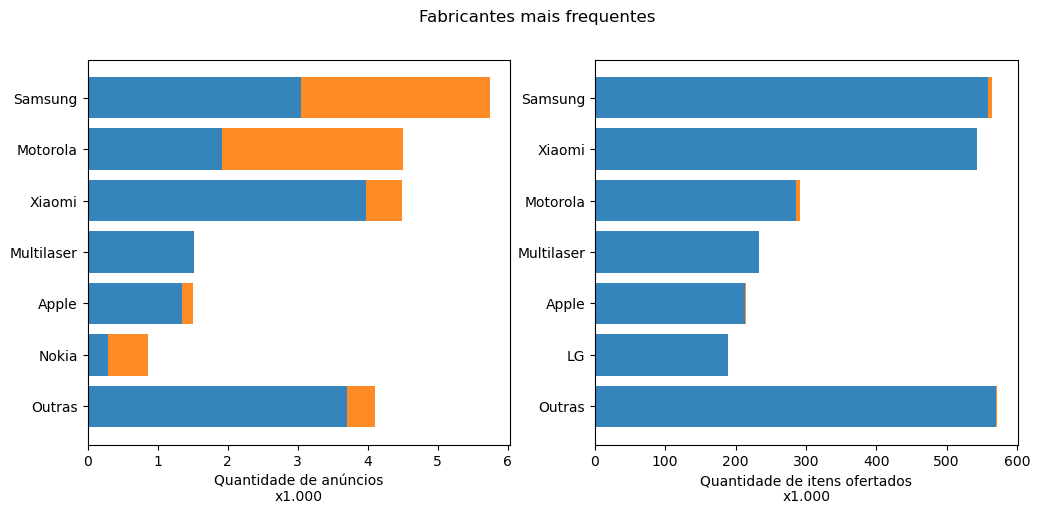

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

labels_items = df_top_brands_items.index.values

values_items_new = df_top_brands_items['Novo'].values/1000
values_items_used = df_top_brands_items['Usado'].values/1000

labels_quantity = df_top_brands_quantity.index.values
values_quantity_new = df_top_brands_quantity['Novo'].values/1000
values_quantity_used = df_top_brands_quantity['Usado'].values/1000

y_pos = np.arange(len(labels_items))

alpha=0.9

axs[0].barh(y_pos, values_items_new, alpha=alpha)
axs[0].barh(y_pos, values_items_used,left=values_items_new, alpha=alpha)
axs[0].set_yticks(y_pos, labels=labels_items)
axs[0].invert_yaxis()
axs[0].set_xlabel('Quantidade de anúncios\nx1.000')

axs[1].barh(y_pos, values_quantity_new, alpha=alpha)
axs[1].barh(y_pos, values_quantity_used, left=values_quantity_new, alpha=alpha)
axs[1].set_yticks(y_pos, labels=labels_quantity)
axs[1].invert_yaxis()
axs[1].set_xlabel('Quantidade de itens ofertados\nx1.000')

plt.suptitle('Fabricantes mais frequentes')
plt.show()

## Fabricantes mais frequentes por tipo de loja

### Quantidade de anúncios

In [20]:
n_top = 6
# top brands items
df_top_brands = df_cellphones.pivot_table(index='brand',columns='is_official_store',values='id',aggfunc='count').fillna(0)
df_top_brands.columns = df_top_brands.columns.map(map_official_store)
df_top_brands['Total'] = df_top_brands.sum(axis=1)
df_top_brands = df_top_brands.sort_values(by='Total',ascending=False)
df_top_brands = df_top_brands.astype(int)

df_top_brands_items = df_top_brands.iloc[:n_top]
df_top_brands_items.loc['Outras'] = df_top_brands.iloc[n_top:].sum()
df_top_brands_items['% Loja Independente'] = round(df_top_brands_items['Loja Independente']/df_top_brands_items['Total'],2)

df_top_brands_items.columns.name = 'Tipo de loja'
df_top_brands_items.index.name = 'Fabricante'

df_top_brands_items

Tipo de loja,Loja Independente,Loja Oficial,Total,% Loja Independente
Fabricante,,,,
Samsung,5292,459,5751,0.92
Motorola,4335,166,4501,0.96
Xiaomi,4438,57,4495,0.99
Multilaser,1340,183,1523,0.88
Apple,942,565,1507,0.63
Nokia,852,15,867,0.98
Outras,3781,329,4110,0.92


### Quantidade de produtos disponibilizados para venda

In [21]:
# top brands items
df_top_brands = df_cellphones.pivot_table(index='brand',columns='is_official_store',values='initial_quantity',aggfunc='sum').fillna(0)
df_top_brands.columns = df_top_brands.columns.map(map_official_store)
df_top_brands['Total'] = df_top_brands.sum(axis=1)
df_top_brands = df_top_brands.sort_values(by='Total',ascending=False)
df_top_brands = df_top_brands.astype(int)

df_top_brands_quantity = df_top_brands.iloc[:n_top]
df_top_brands_quantity.loc['Outras'] = df_top_brands.iloc[n_top:].sum()
df_top_brands_quantity['% Loja Independente'] = round(df_top_brands_quantity['Loja Independente']/df_top_brands_quantity['Total'],2)

df_top_brands_quantity.columns.name = 'Tipo de loja'
df_top_brands_quantity.index.name = 'Fabricante'

df_top_brands_quantity

Tipo de loja,Loja Independente,Loja Oficial,Total,% Loja Independente
Fabricante,,,,
Samsung,76254,487703,563957,0.14
Xiaomi,540035,3907,543942,0.99
Motorola,39432,252172,291604,0.14
Multilaser,116863,116929,233792,0.50
Apple,57452,156870,214322,0.27
LG,51455,137733,189188,0.27
Outras,399496,172937,572433,0.70


## Modelos mais frequentes

In [22]:
n_top = 12

# top models items
df_top_models = df_cellphones.pivot_table(index=['brand','model'],columns='condition',values='id',aggfunc='count').fillna(0)
df_top_models.columns = df_top_models.columns.map(map_condition)
df_top_models['total'] = df_top_models.sum(axis=1)
df_top_models = df_top_models.sort_values(by='total',ascending=False)
df_top_models = df_top_models.astype(int)

df_top_models_items = df_top_models.iloc[:n_top]
df_top_models_items.loc['Outras'] = df_top_models.iloc[n_top:].sum()
df_top_models_items

condition,Novo,Usado,total
"(Xiaomi, 13C)",470,9,479
"(Xiaomi, Poco X6 Pro 5G)",360,1,361
"(Xiaomi, Note 13 Pro 5G)",323,2,325
"(Xiaomi, Poco X6 5G)",284,2,286
"(Xiaomi, Note 13 4G)",206,6,212
"(Apple, iPhone 15 Pro Max)",171,3,174
"(Xiaomi, Poco C65)",160,2,162
"(Xiaomi, 12)",141,15,156
"(Multilaser, Flip Vita)",147,3,150
"(Apple, iPhone 13)",111,1,112


In [23]:
# top brands quantity
df_top_models = df_cellphones.pivot_table(index=['brand','model'],columns='condition',values='initial_quantity',aggfunc='sum').fillna(0)
df_top_models.columns = df_top_models.columns.map(map_condition)
df_top_models['total'] = df_top_models.sum(axis=1)
df_top_models = df_top_models.sort_values(by='total',ascending=False)
df_top_models = df_top_models.astype(int)

df_top_models_quantity = df_top_models.iloc[:n_top]
df_top_models_quantity.loc['Outras'] = df_top_models.iloc[n_top:].sum()
df_top_models_quantity

condition,Novo,Usado,total
"(LG, B220)",160955,0,160955
"(Samsung, A15 4G)",144725,9,144734
"(Xiaomi, 13C)",77866,9,77875
"(Apple, iPhone 13)",71245,1,71246
"(Xiaomi, Poco C65)",57730,2,57732
"(Xiaomi, Note 13 Pro 5G)",55997,2,55999
"(Samsung, A15 5G Dual Sim)",54600,1,54601
"(Apple, iPhone 14)",47759,0,47759
"(Samsung, S23)",45311,11,45322
"(Positivo P28, Celular positivo p28 dual sim: 24 mb preto, 32 mb ram)",44800,0,44800


As quantidades podem estar superestimadas pois alguns vendedores cadastram mais de um anúncio para o mesmo produto.

## Análise de EAN

Premissa: EAN informado nos anúncios de lojas oficiais é o legítimo do aparelho

In [32]:
df_cellphones.columns

Index(['id', 'title', 'seller_id', 'category_id', 'official_store_id', 'price',
       'currency_id', 'initial_quantity', 'condition', 'permalink', 'warranty',
       'catalog_product_id', 'date_created', 'last_updated', 'status',
       'item_condition', 'brand', 'model', 'detailed_model',
       'anatel_homologation_number', 'cellphones_anatel_homologation_number',
       'gtin', 'empty_gtin_reason', 'warranty_type', 'has_gtin',
       'is_official_store', 'official_store_name', 'sch_number',
       'valid_sch_number', 'info_ean', 'valid_gtin'],
      dtype='object')

In [53]:
columns_to_keep = ['gtin', 'sch_number']
df_gtin = df_cellphones[(df_cellphones['is_official_store']==True)&(df_cellphones['has_gtin']==1)][columns_to_keep]
df_gtin = df_gtin.drop_duplicates()

columns_to_keep = ['id', 'title', 'has_gtin', 'is_official_store', 'sch_number', 'gtin']
df_check_gtin_sch = df_cellphones[df_cellphones['has_gtin']==1][columns_to_keep]
df_check_gtin_sch = df_check_gtin_sch.merge(df_gtin,on='sch_number')
df_check_gtin_sch['gtin_ok'] = df_check_gtin_sch['gtin_x']==df_check_gtin_sch['gtin_y']
df_check_gtin_sch[df_check_gtin_sch['gtin_ok']==False].sample(10)

,id,title,has_gtin,is_official_store,sch_number,gtin_x,gtin_y,gtin_ok
7000,MLB4376702816,Apple iPhone 15 Pro Max (256 Gb) - Titânio Pre...,1,True,127822301993,0195949048104,0195949048647,False
12877,MLB3678432949,"Smartphone Samsung Galaxy A55 5g Azul Escuro, ...",1,True,235492300953,7892509135665,7892509135610,False
1312,MLB4102158100,Samsung Galaxy A9 (2018) Dual Sim 128 Gb Preto...,1,False,061851800953,7892509105057,7892509104975,False
3530,MLB3313970167,Apple iPhone 14 (256 Gb) - (product)red - Dist...,1,True,109862201993,0194253410690,0194253409045,False
3936,MLB3633971106,"iPhone 14 Apple (256gb) Estelar, Tela De 6,1 , 5g",1,True,109862201993,7908317351606,7908317351613,False
7592,MLB3511013605,Apple iPhone 15 Pro (128 Gb) - Titânio Natural...,1,True,127832301993,0195949018787,0195949020407,False
5448,MLB3391195715,Samsung Galaxy A04e 64 Gb Azul 4 Gb Ram,1,False,138462200953,7892509126779,7892509126731,False
6178,MLB4851519956,Samsung Galaxy S23 Ultra 256gb 12ram Verde Cor...,1,False,171532200953,7892509126632,7892509127967,False
3030,MLB3531441823,Smartphone Galaxy A03 Tela 6.5'' 64gb 4ram Com...,1,False,152872100953,7894443120295,7892509125567,False
3703,MLB3488334188,"iPhone 14 Apple (128gb) Meia-noite, Tela De 6,...",1,True,109862201993,7908317353044,7908317351590,False


In [55]:
df_cellphones[df_cellphones['title'].str.contains('iPhone 15 Pro Max')][['title', 'gtin']]

,title,gtin
4172,"iPhone 15 Pro Max 512gb Azul Tela 6,7 5g Câme...",7908317358827
4200,Apple iPhone 15 Pro Max (256 Gb) - Titânio Azu...,0195949048647
4205,Apple iPhone 15 Pro Max (512 Gb) - Titânio Pre...,0195949048821
4218,Apple iPhone 15 Pro Max (256 Gb) - Titânio Azu...,7908317358780
4221,Apple iPhone 15 Pro Max (512 Gb) - Titânio Azu...,7908317358827
...,...,...
22329,Apple iPhone 15 Pro Max (1 Tb) - Titânio Branco,0194253124030
22380,iPhone 15 Pro Max Apple 256gb - Titânio Branco,0000000000000
22387,iPhone 15 Pro Max Apple 256gb - Titânio Preto,0000000000000
22560,iPhone 15 Pro Max 512gb - Titânio Natural,0000000000000
